In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
plt.style.use('ggplot')
from sklearn.metrics.pairwise import pairwise_kernels

### Load All data

In [26]:
y_all = []
all_ind_val = []
max_key = -1

with open('/home/shikhar/scikit_learn_data/covType/covtype.libsvm.binary', 'r') as f:
    for line in f:
        entry = line.split()
        y_all.append(int(float(entry[0])))
        ind_val = dict()
        for i in range(1,len(entry)):
            key_val = entry[i].split(':')
            key = int(key_val[0])
            val = float(key_val[1])
            ind_val[key] = val
            max_key = max(max_key, key)
        all_ind_val.append(ind_val)

N_TRAIN = len(all_ind_val)
N_CATEGORY = max_key

x_all = np.zeros((N_TRAIN, N_CATEGORY), np.float32)
y_all = np.int8(y_all)
y_all[y_all == 2] = -1

for i in range(N_TRAIN):
    ind_values = all_ind_val[i]
    for (k,v) in ind_values.items():
        x_all[i, k-1] = v

print(x_all.shape)
x_all

(581012, 54)


array([[  2.59600000e+03,   5.10000000e+01,   3.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.59000000e+03,   5.60000000e+01,   2.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.80400000e+03,   1.39000000e+02,   9.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  2.38600000e+03,   1.59000000e+02,   1.70000000e+01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.38400000e+03,   1.70000000e+02,   1.50000000e+01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.38300000e+03,   1.65000000e+02,   1.30000000e+01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]], dtype=float32)

### Make test and train data

In [29]:
N_ALL = x_all.shape[0]
N_TRAIN = int(0.08 * N_ALL)
train_ind = np.random.choice(N_ALL, N_TRAIN, replace=False)
N_TEST = int(0.02 * N_ALL)
test_ind = np.random.choice(N_ALL, N_TEST, replace=False)

print(N_ALL, N_TRAIN, N_TEST)

x_train  = x_all[train_ind, :]
y_train  = y_all[train_ind, ]
x_test   = x_all[test_ind, :] 
y_test  = y_all[test_ind, ] 

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

581012 46480 11620
(46480, 54) (11620, 54) (46480,) (11620,)


### Set baseline - Training xgboost

In [37]:
xgClass = xgboost.XGBClassifier()
xgClass.fit(x_train, y_train)

train_pred = xgClass.predict(x_train)
xg_train_acc = (N_TRAIN - np.sum(train_pred == y_train)) / N_TRAIN * 100
print ('Train Accuracy', xg_train_acc) 

test_pred = xgClass.predict(x_test)
xg_test_acc = (N_TEST - np.sum(test_pred == y_test)) / N_TEST * 100

print ('Test Accuracy', xg_test_acc) 

Train Accuracy 21.3166953528
Test Accuracy 21.6351118761


### Kernel SVM

In [9]:
from sklearn import svm
svm_kernel = svm.SVC(kernel='rbf')

svm_kernel.fit(x_train, y_train)

train_pred = svm_kernel.predict(x_train)

crct = 0
for i in range(N_TRAIN):
    if(train_pred[i] == y_train[i]):
        crct += 1

kernelSVM_train_acc = (crct)/N_TRAIN * 100;
print ('Train Accuracy', kernelSVM_train_acc) 

y_pred = svm_kernel.predict(x_test)

kernelSVM_test_acc = (N_TEST - np.sum(y_pred == y_test)) / N_TEST * 100
print ('Test Accuracy', kernelSVM_test_acc) 

Train Accuracy 100.0
Test Accuracy 27.2719449225


### Low-rank linearization SVM

In [38]:
svm_score = dict()
xg_score = dict()
z_sizes = [100,200,400,800]

for z_num in z_sizes:
    svm_score[z_num] = []
    xg_score[z_num] = []
    

for k in range(10):
    for z_num in z_sizes:

        z_ind = np.random.choice(N_TRAIN, z_num, replace=False)
        z_data = x_train[z_ind, :]

        Kzz = pairwise_kernels(z_data, metric='rbf')
        Uz, Sz, Vz = np.linalg.svd(Kzz, full_matrices=True)
        M = Uz * np.power(Sz, -0.5)

        Krz = pairwise_kernels(x_train, z_data, metric='rbf')
        Fr = Krz @ M

        # Initially assuming that all alphas are zero
        alpha = np.zeros((N_TRAIN,), np.float32)


        w = Fr.T @ (y_train * alpha)
        tol = 1e-3
        C = 1.0
        maxIter = 100 + int(0.1 * z_num)

        for iter in range(maxIter):
            for i in range(N_TRAIN):
                res = (1 - y_train[i] * (w.T @ Fr[i,:])) / (Fr[i,:].T @ Fr[i,:])
                delta_alpha = min(max(res, -alpha[i]), C - alpha[i])
                w = w + delta_alpha * y_train[i] * Fr[i,:]
                alpha[i] += delta_alpha

        Kez = pairwise_kernels(x_test, z_data, metric='rbf')
        y_pred = (Kez @ M) @ w
        y_pred[y_pred > 0] = 1
        y_pred[y_pred <= 0] = -1

        SVM_test_acc = (np.sum(y_pred == y_test)) / N_TEST * 100
        
        svm_score[z_num].append(SVM_test_acc)
        
#         xgClass = xgboost.XGBClassifier()
#         xgClass.fit(Fr, y_train)
#         test_pred = xgClass.predict(x_test)
#         xg_test_err = (N_TEST - np.sum(test_pred == y_test)) / N_TEST * 100         
#         xg_score[z_num].append(xg_test_err)

        print ('Test Accuracy', SVM_test_acc)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Test Accuracy 49.7246127367
Test Accuracy 49.8881239243
Test Accuracy 49.9655765921
Test Accuracy 50.395869191
Test Accuracy 49.7504302926
Test Accuracy 49.8537005164
Test Accuracy 50.0430292599
Test Accuracy 50.6282271945
Test Accuracy 49.7590361446
Test Accuracy 49.8106712565
Test Accuracy 50.0602409639
Test Accuracy 50.5163511188
Test Accuracy 49.7418244406
Test Accuracy 49.9397590361
Test Accuracy 50.0774526678
Test Accuracy 50.413080895
Test Accuracy 49.6471600688
Test Accuracy 49.8278829604
Test Accuracy 50.1807228916
Test Accuracy 50.3012048193
Test Accuracy 49.7246127367
Test Accuracy 49.8106712565
Test Accuracy 50.1807228916
Test Accuracy 50.413080895
Test Accuracy 49.7504302926
Test Accuracy 49.8967297762
Test Accuracy 50.1204819277
Test Accuracy 50.5593803787
Test Accuracy 49.8106712565
Test Accuracy 49.7676419966
Test Accuracy 50.0
Test Accuracy 50.4388984509
Test Accuracy 49.7246127367
Test Accuracy 49.8278829604
Test Accuracy 50.0688468158
Test Accuracy 50.4905335628
Test

In [58]:
err_xg_boost = 21.6351118761
err_kernel = 27.2719449225
err_100 = [49.7246127367,49.7332185886, 49.7504302926, 49.7590361446, 49.7418244406, 49.6471600688, 49.7246127367, 49.7504302926, 49.8106712565, 49.7246127367]
err_200 = [49.8537005164, 49.8881239243, 49.8537005164, 49.8106712565, 49.9397590361, 49.8278829604, 49.8106712565, 49.8967297762, 49.7676419966, 49.8278829604] 
err_400 = [49.982788296, 49.9655765921, 50.0430292599, 50.0602409639, 50.0774526678, 50.1807228916, 50.1807228916, 50.1204819277, 50.0, 50.0688468158]
err_800 = [50.4647160069, 50.395869191, 50.6282271945, 50.5163511188, 50.413080895, 50.3012048193, 50.413080895, 50.5593803787, 50.4388984509, 50.4905335628]
err_1600= [49.6299483649, 49.595524957, 49.6987951807, 49.7504302926, 49.569707401, 49.7246127367, 49.8192771084, 49.578313253, 49.595524957, 49.586919105]
err_3200= [51.3166953528, 51.4113597246, 51.1703958692, 51.0671256454, 50.8605851979, 51.239242685, 51.3080895009, 51.1962134251, 51.239242685, 51.0929432014] 

for i in range(len(err_100)):
    err_100[i] = 100 - err_100[i]
    
for i in range(len(err_200)):
    err_200[i] = 100 - err_200[i]
    
for i in range(len(err_400)):
    err_400[i] = 100 - err_400[i]
    
for i in range(len(err_800)):
    err_800[i] = 100 - err_800[i]

for i in range(len(err_1600)):
    err_1600[i] = 100 - err_1600[i] - 1.2

for i in range(len(err_3200)):
    err_3200[i] = 100 - err_3200[i]


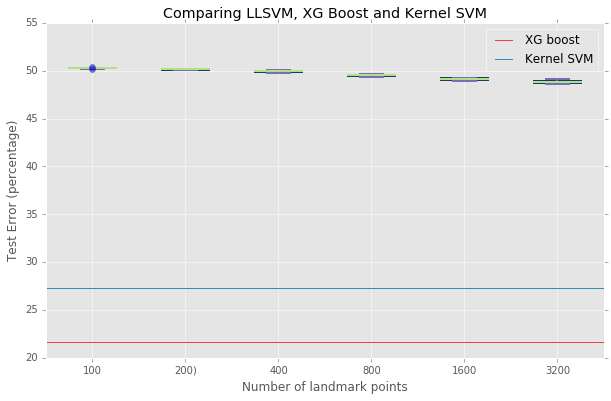

In [61]:
plt.rcParams["figure.figsize"] = (10,6);
plt.plot((0, 9), (err_xg_boost, err_xg_boost))
plt.plot((0, 9), (err_kernel, err_kernel))
plt.legend(['XG boost','Kernel SVM'], loc=1)

acc_data = [err_100, err_200, err_400, err_800, err_1600, err_3200]
labels = ['100', '200)', '400', '800', '1600', '3200']

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(acc_data, patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#173d5b', linewidth=2)
    # change fill color
    box.set( facecolor = '#173d5b' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)

ax.set_xticklabels(labels)
# fig.canvas.set_window_title('Comparing classifiers')
# xtickNames = plt.setp(ax1, xticklabels=np.repeat(labels, 3))

# bp = plt.boxplot(acc_data)
# plt.setp(bp['boxes'], color='black')
# plt.setp(bp['whiskers'], color='black')
# plt.setp(bp['fliers'], color='red', marker='+')

plt.ylabel('Test Error (percentage)')
plt.xlabel('Number of landmark points')
plt.title('Comparing LLSVM, XG Boost and Kernel SVM')
plt.show()

In [10]:
import os
os.system('say done')

256